# **Univariate Linear Regression**
### Parameter estimation by solving linear system of equations
We can perform linear regression to find parameters of systems which can be modeled with linear equations. In this notebook, we will use temperature data obtained from 1D steady-state heat flow across an infinitely long plate to find the equation governing spatial variation of temperature along the plate's width. In out case, we have only one feature - the distance from one end of the plate - which means we'll have two parameters to estimate.

In [10]:
# Dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### **Generating data from the forward model**
Let's create some data which follows the model. This will be used to test the regressor we program later. The forward model for 1D conduction is given by the expression on the left hand side. For steady-state conduction with no heat generation (we will relax this assumption later) and constant thermal conductivity $k$, the equation reduces to one on the right. 

$$
\frac{\partial}{\partial x}\left(k\frac{\partial T}{\partial x}\right)+q_{v}=\rho C_{p}\frac{\partial T}{\partial t}\quad\Rightarrow\quad\frac{\partial^{2}T}{\partial x^{2}}=0\quad\Rightarrow\quad T(x)=\alpha_{0}+\alpha_{1}x
$$

The true values of $\alpha_{0}$ and $\alpha_{1}$ are dictated by the system's boundary conditions. $\alpha_{1}$ is proportional to the heat flux through the system and $\alpha_{0}$ is the temperature at $x=0$. For our case, assume we're using a steel plate ($k \approx 50\; W/mK$) with a heat flux $q = 1000\;W/m^{2}$ flowing from one edge of it. Let the location from where heat flows ($x=0$) be at a steady state temperature of $300\;K$ (this depends on how heat leaves the system, say by natural convection, radiation, or its variants).

This gives us the expected values of $\boxed{\alpha_{0}=300\;K}$ and $\boxed{\alpha_{1}=-20\;K/m}$. We'll generate 100 data points for a plate which is 1 m wide, such that temperature is recorded every 1 cm. Also, we'll add normally distributed noise with mean = 0 and standard deviation = 1 to the data, to loosely account for measurement errors. While training, we will ignore the readings for $x=0.0\;m$ and $x=1.0\;m$. We'll find these using the line fit by our model and compare them with expected values.

Feel free to play around with your own settings of $\alpha_{0}$ and $\alpha_{1}$.

In [2]:
# System parameters
alpha_0 = 300.0
alpha_1 = -20.0
n_samples = 100

# Generating real data
x = np.linspace(0, 1.0, n_samples+1)                             # This gives us 101 points from x = 0.0 to x = 1.0
T_real = alpha_0 + alpha_1*x                                     # Temperature values, based on our equation

# Adding noise
noise = np.random.normal(loc=0, scale=1, size=len(T_real))       # Noise to be added to values of T
T_noisy = T_real + noise                                         # Now we have noisy values of temperature

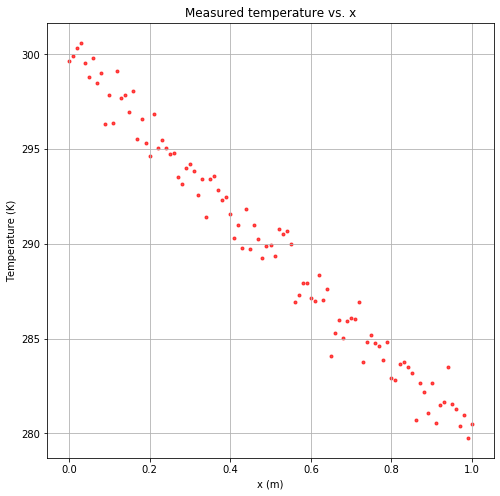

In [3]:
# Plot x vs. T_noisy
plt.figure(figsize=(8, 8))
plt.scatter(x, T_noisy, marker='.', color='red', alpha=0.7)
plt.title('Measured temperature vs. x')
plt.xlabel('x (m)')
plt.ylabel('Temperature (K)')
plt.grid()
plt.show()

Plotting noisy temperatures against $x$, we can clearly see a linear trend.

### **Loss Function and Optimization**

If our fit line approximates temperature (given $x$) well, the error between its prediction and the actual value of temperature should be minimum. Esentially, we would like to solve an optimization problem to obtain those values of parameters which minimize the error function (also called loss function). There are various ways to aggregate the errors from all predictions; the **sum of squared errors** is most widely used, since it always provides a unique solution. It has two important properties:
1. Positive and negative errors are treated equally
2. Larger errors are penalized more than smaller errors

The functional form of SSE is as follows. This optimization problem is therefore called **Least Squares Regression** (LSR in short). 

$$
\mathcal{L}(\alpha)=\frac{1}{2m}\sum_{i=1}^{m}\left(T^{(i)}-T_{fit}^{(i)}\right)^{2}=\frac{1}{2m}\sum_{i=1}^{m}\left(T^{(i)}-\alpha_{0}-\alpha_{1}x^{(i)}\right)^{2}
$$

We take an average over all examples to keep the numbers small. We also divide by 2 for computational convenience, which will be evident soon.

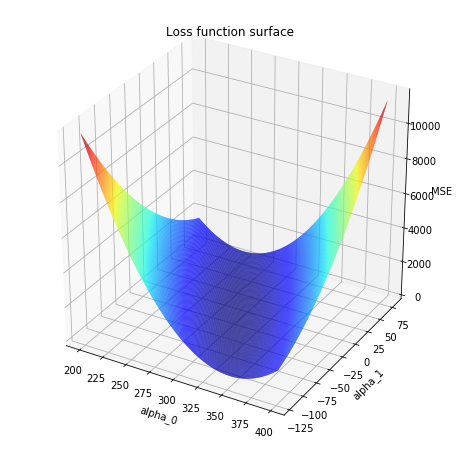

In [4]:
def get_sse(alpha_0, alpha_1, x, y):
    return (0.5/len(x))*np.sum((y - alpha_0 - alpha_1*x)**2)

# Create a meshgrid of alpha space and get SSE for each pair of parameters
sse_vals = []
a0, a1 = np.meshgrid(np.arange(200, 400, 1), np.arange(-120, 80, 1))
for pair in np.c_[a0.ravel(), a1.ravel()]:
    sse_vals.append(get_sse(pair[0], pair[1], x, T_real))
y_grid = np.array(sse_vals).reshape(a0.shape)

# Plot the surface
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a0, a1, y_grid, rstride=1, cstride=1, cmap='jet')
ax.set_xlabel('alpha_0')
ax.set_ylabel('alpha_1')
ax.set_zlabel('MSE')
plt.title('Loss function surface')
plt.show()

Not the best view for a paraboloid, but it forms one with a minima at $\alpha_{0}=300$ and $\alpha_{1}=-20$. In fact, this function has a global minimum at these values. Where this function attains its minimum, we expect its derivative to be zero with respect to both $\alpha_{0}$ and $\alpha_{1}$. We get two equations from that:

$$
\frac{\partial\mathcal{L}}{\partial\alpha_{0}}=-\frac{1}{m}\sum_{i=1}^{m}\left(T^{(i)}-\alpha_{0}-\alpha_{1}x^{(i)}\right)=0
$$
.
$$
\frac{\partial\mathcal{L}}{\partial\alpha_{1}}=-\frac{1}{m}\sum_{i=1}^{m}\left(T^{(i)}-\alpha_{0}-\alpha_{1}x^{(i)}\right)\cdot x^{(i)}=0
$$

This can be compactly (and conveniently) transformed into this matrix equation ($m$ is the number of measurements).

$$
\left[\begin{array}{cc}
m & \sum x^{(i)}\\
\sum x^{(i)} & \sum\left(x^{(i)}\right)^{2}
\end{array}\right]\cdot\left[\begin{array}{c}
\alpha_{0}\\
\alpha_{1}
\end{array}\right]=\left[\begin{array}{c}
\sum T^{(i)}\\
\sum T^{(i)}x^{(i)}
\end{array}\right]
$$

Estimated value of alpha_0 	 : 	 299.88347397976634
Estimated value of alpha_1 	 : 	 -20.107288751712304



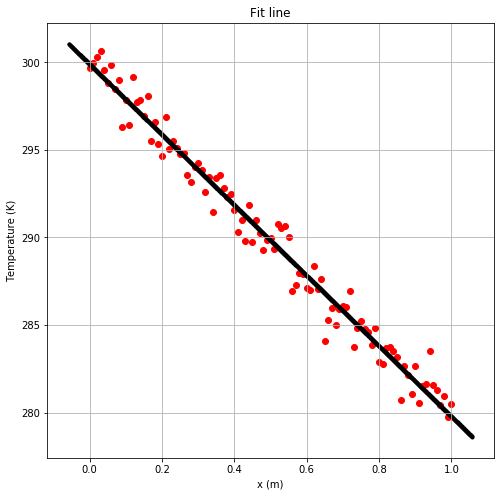

In [14]:
# Perform the matrix operations to get alpha_0 and alpha_1
A = np.array([[len(x), sum(x)],
              [sum(x), sum(x**2)]])
b = np.array([[sum(T_noisy)],
              [sum(T_noisy * x)]])

fit_params = np.dot(np.linalg.inv(A), b)

# Print estimated values
print("Estimated value of alpha_0 \t : \t {}".format(fit_params[0][0]))
print("Estimated value of alpha_1 \t : \t {}\n".format(fit_params[1][0]))

# Visualizing the fit line
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(x, T_noisy, color='red', marker='o')
x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
fit_vals = fit_params[0] + fit_params[1]*x_vals
ax.scatter(x_vals, fit_vals, color='black', marker='.')
plt.title('Fit line')
plt.xlabel('x (m)')
plt.ylabel('Temperature (K)')
plt.grid()
plt.show()

It seems like we have estimated the parameters really well. Below is a parity plot showing how our predictions look against actual values of temperature. The black line is indicates the ideal distribution of measured and predicted values (equal), and has slope = 1. All points above the line were underestimated and those below were overestimated by our model.

**NOTE**: If you run the algorithm several times, you will notice that the estimated values of parameters change slightly in each run. This is because of the way inverse is calculated, known as the **Moore-Penrose Pseudoinverse**. It is an iterative method to compute the inverse of a matrix, which is used to obtain an inverse of singular matrices (for linear system of equations with infinite solutions). Also, we are adding different amounts of random noise everytime we run the algorithm.

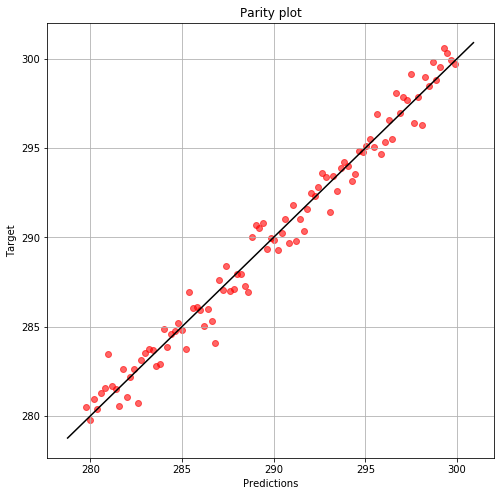

In [6]:
# Get temperature predictions for x with estimated parameters
predicted_T = fit_params[0] + fit_params[1]*x

# Parity plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(predicted_T, T_noisy, c='red', alpha=0.6)
lim = np.linspace(*ax.get_xlim())
ax.plot(lim, lim, color='black')
plt.xlabel('Predictions')
plt.ylabel('Target')
plt.title('Parity plot')
plt.grid()
plt.show()

### **Measuring goodness of fit**

We use certain metrics to quantify the goodness of our model's fit to the data. Three of them are **coefficient of determination** ($R^{2}$), **correlation coefficient** ($R$) and **standard error**. They are calculated using the expressions shown below. $\overline{T}$ is the mean of measured temperatures.

$$
S_{t}=\sum_{i=1}^{m}\left(T^{(i)}-\overline{T}\right)^{2}\quad;\quad S_{r}=\sum_{i=1}^{m}\left(T^{(i)}-T_{fit}^{(i)}\right)^{2}
$$
.
$$
R^{2}=\frac{S_{t}-S_{r}}{S_{t}}\quad;\quad R=\sqrt{\frac{S_{t}-S_{r}}{S_{t}}}\quad;\quad SE=\sqrt{\frac{S_{r}}{m-2}}
$$

In [7]:
# Make a dataframe with x, T_noisy and predicted_T

data = np.vstack((x.reshape((1, -1)), T_noisy.reshape((1, -1)), predicted_T.reshape((1, -1)))).T
df = pd.DataFrame(data, columns=['x', 'T_measured', 'T_fit'])

df['Mean_deviation'] = (df['T_measured'] - df['T_measured'].mean())**2
df['Fit_deviation'] = (df['T_measured'] - df['T_fit'])**2

print(df)

        x  T_measured       T_fit  Mean_deviation  Fit_deviation
0    0.00  299.677517  299.883474       96.976938       0.042418
1    0.01  299.940036  299.682401      102.216276       0.066376
2    0.02  300.326005  299.481328      110.169693       0.713479
3    0.03  300.620049  299.280255      116.428839       1.795048
4    0.04  299.556975  299.079182       94.617364       0.228286
..    ...         ...         ...             ...            ...
96   0.96  281.306650  280.580477       72.644599       0.527327
97   0.97  280.407699  280.379404       88.776541       0.000801
98   0.98  280.961849  280.178331       78.641071       0.613901
99   0.99  279.755448  279.977258      101.493165       0.049200
100  1.00  280.480500  279.776185       87.409962       0.496059

[101 rows x 5 columns]


In [8]:
# Calculate goodness of fit parameters
S_t, S_r = df['Mean_deviation'].sum(), df['Fit_deviation'].sum()
R_2 = (S_t - S_r)/S_t
SE = np.sqrt(S_r/(len(x) - 2))

print("Coefficient of determination \t : \t {}".format(R_2))
print("Correlation coefficient \t : \t {}".format(R_2**0.5))
print("Standard error for fit \t\t : \t {}\n".format(SE))

Coefficient of determination 	 : 	 0.9768516647679624
Correlation coefficient 	 : 	 0.9883580650594006
Standard error for fit 		 : 	 0.9114894330418715



**The correlation coefficient is very close to 1.0, indicating that our fit is pretty good.**

Here is an interesting observation. On the top is a bar plot indicating the square deviation of our model's predictions from actual temperatures. On the bottom is another bar plot showing the square of the noise added to real temperature values to generate noisy temperatures. It seems as if the fit model has been able to characterize the noise in our data fairly well. Perhaps, we could use this methods to denoise measured data that we receive from experiments.

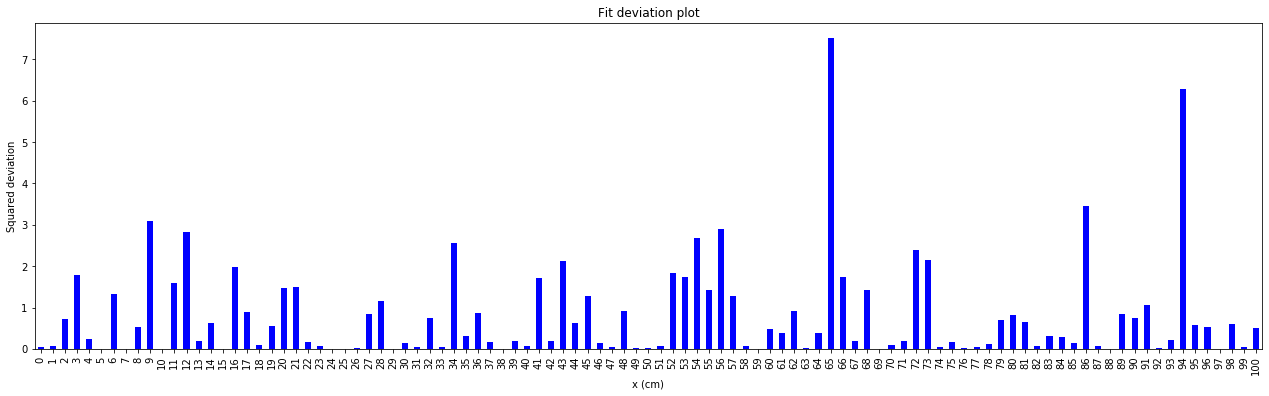

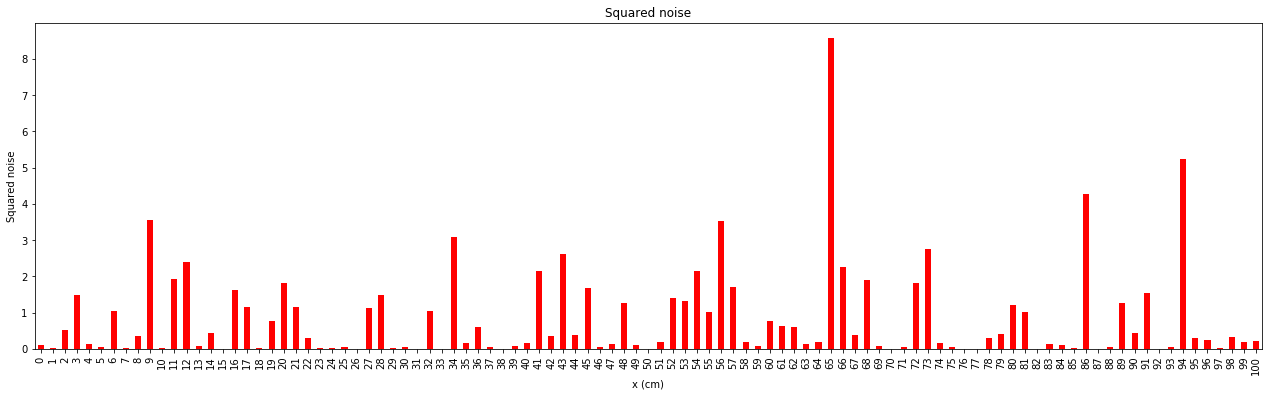

In [9]:
# Fit deviation
df['Fit_deviation'].plot(kind='bar', color='blue', figsize=(22, 6))
plt.title('Fit deviation plot')
plt.xlabel('x (cm)')
plt.ylabel('Squared deviation')
plt.show()

# Squared noise
pd.Series(noise**2).plot(kind='bar', color='red', figsize=(22, 6))
plt.title('Squared noise')
plt.xlabel('x (cm)')
plt.ylabel('Squared noise')
plt.show()